<a href="https://colab.research.google.com/github/mskansara/multivariate_lstm/blob/master/DroughtPrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

0.66
Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_73 (LSTM)               (None, 1, 128)            69632     
_________________________________________________________________
lstm_74 (LSTM)               (None, 1, 64)             49408     
_________________________________________________________________
lstm_75 (LSTM)               (None, 1, 64)             33024     
_________________________________________________________________
lstm_76 (LSTM)               (None, 1, 64)             33024     
_________________________________________________________________
lstm_77 (LSTM)               (None, 1, 64)             33024     
_________________________________________________________________
lstm_78 (LSTM)               (None, 32)                12416     
_________________________________________________________________
dense_13 (Dense)             (None, 1)          

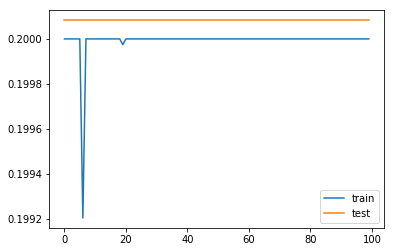

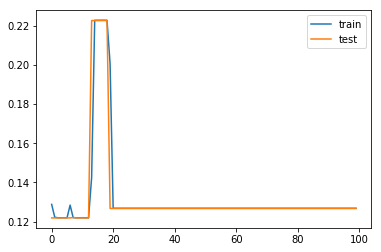

[0.12670115110675453, 0.20008293589800688]


In [17]:
import tensorflow as tf
import numpy as np
from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import Dense, LSTM, RepeatVector, TimeDistributed
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from numpy import array
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from keras.optimizers import Adam
import math

NAME='DroughtPrediction'

# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

#Get dataset
# dataset = pd.read_csv('RoughSPI.csv')
dataset = read_csv('pollution.csv', header=0, index_col=0)
dataset = dataset.drop(['year', 'month', 'day','hour'],axis=1)
scaled = dataset.values

# dataset = pd.read_csv('pollutioncopy.csv', header=0, index_col=0)
# dataset = dataset.drop(['cbwd'], axis=1)

# dataset.index = dataset['Time']
# dataset.index.name = 'Time'
# dataset = dataset.drop(['Time','Location'], axis=1)
# print(len(dataset))

# print(dataset.head(5))

# Standardize the data
# dataset_columns = dataset.columns
# scaler = preprocessing.StandardScaler()
# dataset = scaler.fit_transform(dataset)
# dataset = pd.DataFrame(dataset,columns=dataset_columns)
# scaler = MinMaxScaler(feature_range=(0, 1))
# dataset = scaler.fit_transform(dataset)

# print(dataset[0])

reframed = series_to_supervised(dataset, 1, 1)
# print(reframed)


#Splitting features and output
# X_train, X_test, Y_train, Y_test = train_test_split(dataset[:,:-1], dataset[:,-1], test_size=0.15)
values = reframed.values
n_train_hours = 39000

train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# print(len(train))
# print(len(test))

# split into input and outputs
X_train,Y_train = train[:, :-1], train[:, -1]
X_test, Y_test = test[:, :-1], test[:, -1]

X_train = np.reshape(X_train, (X_train.shape[0],1,X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0],1,X_test.shape[1]))
print(Y_test[0])

# print(Y_train)

#Create a model
model = Sequential()

#Stacked LSTM
model.add(LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2]),activation='relu', return_sequences=True))
model.add(LSTM(64, activation='relu', return_sequences=True))
model.add(LSTM(64, activation='relu', return_sequences=True))
model.add(LSTM(64, activation='relu', return_sequences=True))
model.add(LSTM(64, activation='relu', return_sequences=True))
model.add(LSTM(32, activation='relu', return_sequences=False))
model.add(Dense(1, activation='relu'))
print(model.summary())
tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

model.compile(optimizer='Adam', loss='mean_squared_error', metrics=['accuracy'])


# fit model
history = model.fit(X_train,Y_train,
                    epochs=100, 
                    callbacks=[tensorboard],
                    validation_data = (X_test,Y_test)
                    )

# plot history
pyplot.plot(history.history['acc'], label='train')
pyplot.plot(history.history['val_acc'], label='test')
pyplot.legend()
pyplot.show()

# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()
trainPredict = model.predict(X_train)
testPredict = model.predict(X_test)

# Score model
score = model.evaluate(X_test, Y_test, verbose=0)
print(score)

#Calculate root mean squared error
# trainScore = math.sqrt(mean_squared_error(Y_train[0], trainPredict[:,0]))
# print('Train Score: %.2f RMSE' % (trainScore))
# testScore = math.sqrt(mean_squared_error(Y_test[0], testPredict[:,0]))
# print('Test Score: %.2f RMSE' % (testScore))
